# Connect and authorize google drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# !ls

# Download data

In [ ]:
!wget -O galah_dr4_allstar_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits
!wget -O galah_dr4_vac_dynamics_240705.fits https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_vac_dynamics_240705.fits
!wget -O ONeill2024_LocalBubble_Shell_xyz.fits https://dataverse.harvard.edu/api/access/datafile/8955365
# !wget -O ONeill2024_LocalBubble_ShellProperties_A0.5.fits https://dataverse.harvard.edu/api/access/datafile/8943783

# Install

In [ ]:
# ! pip install healpy --quiet

In [ ]:
# ! pip install wget --quiet

# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable ## for Plotting L.O.S Samples
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [ ]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

print('Torch version: ', torch.__version__)
print('torch.version.cuda: ', torch.version.cuda)

print("Is CUDA enabled?",torch.cuda.is_available())

device:  cpu
device_count:  0
Torch version:  2.6.0+cu124
torch.version.cuda:  12.4
Is CUDA enabled? False


# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/GASKAP

# Fcn

In [ ]:
vlsr_sun = 15.17 # km/s, see Sven's paper GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def normalize_spectrum(spectrum):
    min_val = np.min(spectrum)
    max_val = np.max(spectrum)

    # Handle the case where all values are the same
    if max_val == min_val:
        return np.zeros_like(spectrum)  # Return a spectrum of zeros or any consistent value

    # Apply min-max normalization
    normalized_spectrum = (spectrum - min_val) / (max_val - min_val)
    return normalized_spectrum

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
galah0 = Table.read(allstar_file)
med_dist_lim = 3000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah_sm = galah0[
    (glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > lmc_glat[0]) & (glat < lmc_glat[1]) & (np.log10(galah0['ew_k_is']) > -1.3) &
    (med_dist > 250.) & (med_dist < 300.) &
    (galah0['rv_k_is'] > -100.) & (galah0['rv_k_is'] < 120.)
  ]
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

# For all HI absoprtion detections

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)
ggdf.head()

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_with_gaussfit_ki_3sigma_thres_matching.csv
(302, 19)


,src_id,src_name,src_glon,src_glat,nhi,sig_nhi,nhi_thin,star_id,r_med,ew_ki_ism,amp_ki_ism,res_max_ki_ism,ki_ism_vlsr_obs,ki_ism_avg_vlsr_obs,ki_ism_sig_vlsr_obs,emt_min_vlsr,vlsr_hi_ki_diff,vlsr_diff_min,n_nearby_stars
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,0.093995,0.105074,-6.150478,-6.150478,5.000000,-2.045776,4.104702,4.104702,1
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,0.126684,0.132525,3.705640,3.705640,5.000000,1.225603,2.480036,2.480036,1
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,0.064996,0.106274,9.394238,9.394238,5.000000,9.945510,0.551272,0.551272,1
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,0.081028,0.124206,4.061161,3.434988,3.535534,5.310693,1.249532,1.249532,2
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,0.065072,0.082032,8.506430,8.506430,5.000000,7.916428,0.590002,0.590002,1


In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]
n_matchings, n_cols = current_ggdf.shape
print('Number of maching LOS: ', n_matchings)

Number of maching LOS:  302


In [ ]:
current_ggdf1 = current_ggdf.merge(df_det, left_on='src_name', right_on='comp_name', how='left')
current_ggdf1

,src_id,src_name,src_glon,src_glat,nhi_x,sig_nhi,nhi_thin_x,star_id,r_med,ew_ki_ism,...,sigRfactor,nhi_y,signhi,nhi_thin_y,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,0,J001424-733911,306.494335,-43.218047,2.730491,0.297817,2.646857,140811005001115,673.530334,0.044314,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,2,J002223-742825,305.562542,-42.505801,2.909353,0.249468,2.823752,141104003301004,1327.229980,0.032836,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
2,14,J004222-754838,303.670829,-41.304667,4.393594,0.182630,4.296437,140814006001141,668.953369,0.058141,...,0.049128,4.393594,0.182630,4.296437,0.104609,2,3.470179,763.060974,0.706301,0.006775
3,27,J010120-781900,302.288489,-38.799206,5.056057,0.246789,4.842613,150706005901396,1055.759033,0.037592,...,0.057009,5.056057,0.246789,4.842613,0.119624,2,3.467137,106.530998,1.022433,0.025780
4,36,J010811-754156,301.554024,-41.384497,4.273245,0.401805,4.051246,150705006401309,931.588501,0.035915,...,0.101715,4.273245,0.401805,4.051246,0.080218,1,3.458012,25.334000,1.136534,0.096351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,365,J052502-693902,280.314613,-32.782629,4.766017,2.412549,4.640839,170108002201154,572.952087,0.031951,...,0.526859,4.766017,2.412549,4.640839,0.198137,2,4.032865,2084.866943,5.417327,0.010648
298,366,J052517-672245,277.639635,-33.132452,4.511694,0.286535,4.293524,161107003901184,834.148254,0.030772,...,0.071462,4.511694,0.286535,4.293524,0.087490,1,3.743918,58.483002,5.421424,0.062218
299,374,J052648-645142,274.632554,-33.315743,4.781825,0.163477,4.665771,171205002601118,446.956665,0.031087,...,0.042330,4.781825,0.163477,4.665771,0.109002,1,3.330268,48.251999,5.446807,0.079754
300,381,J052936-734000,284.896470,-31.671760,6.839853,0.750954,6.669797,180101003601019,492.257507,0.053339,...,0.118554,6.839853,0.750954,6.669797,0.190117,1,3.330268,67.431000,5.493596,0.077935


# Plot examples of KI/HI spectra

src_glon, src_glat:  283.9516051160657 -39.40721427099695
STAR rv_comp_1:  56.71788
ISM KI widths:  0.17229918 6.709213292583198
glon_star, glat_star 284.384 -39.403
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  5.896761113650765 5.598909970290144
glon_star, glat_star 284.384 -39.403


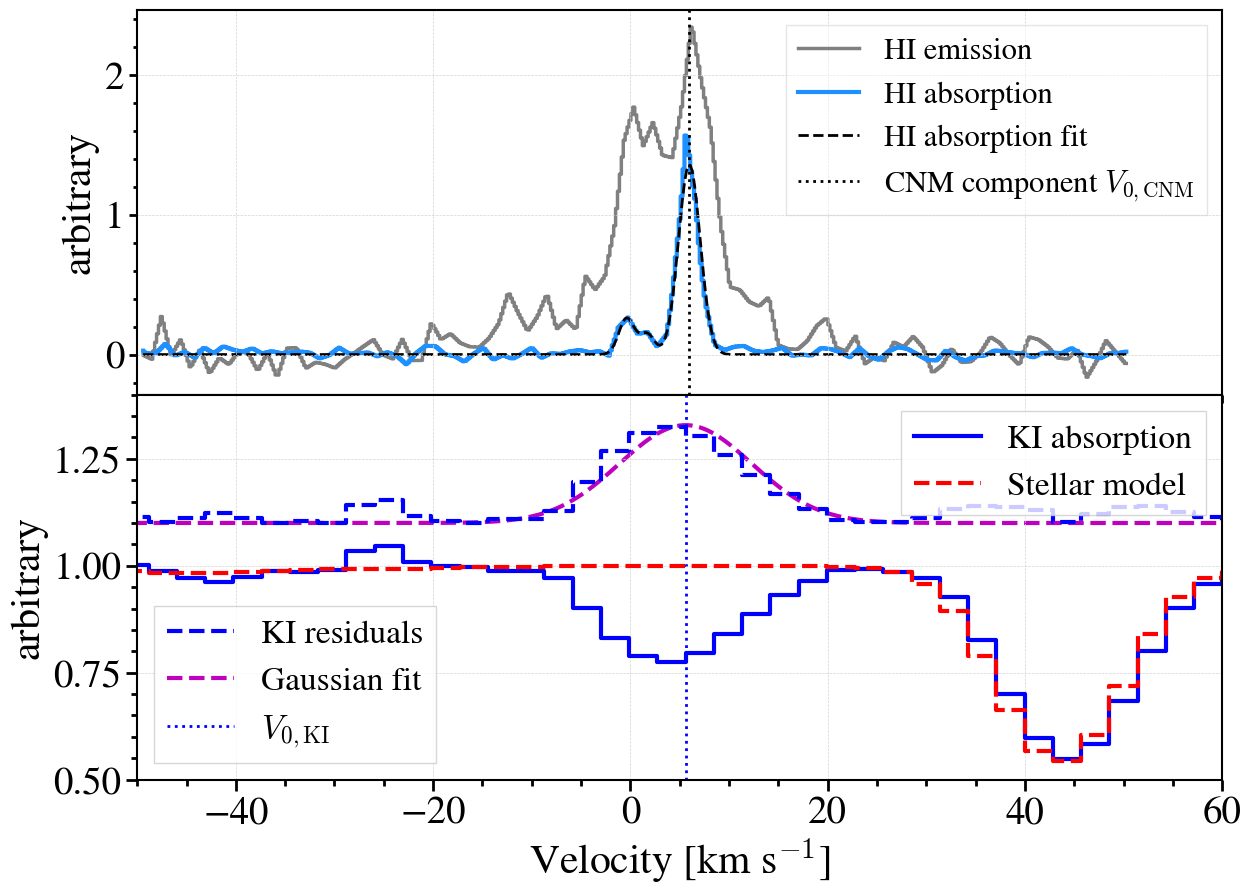

In [ ]:
import matplotlib.gridspec as gridspec
xfactors = {179:0.075, 376: 0.025}


for hi_det_src_id in range(462):
    star_id = ggdf[ggdf.src_id == hi_det_src_id].star_id.values[0]

    if hi_det_src_id not in [179, 376]:
        continue

    # GASKAP source
    gaskap_src = df_det.iloc[hi_det_src_id]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat
    print('src_glon, src_glat: ', src_glon, src_glat)


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    # compute sum of gaussians
    hi_tau_arr = np.zeros_like(vlsr_gaskap)
    for i in range(ncnm):
        hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])


    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'

    closest_star_info = galah[galah['sobject_id'] == star_id]

    glon_star = closest_star_info['l'].data[0]
    glat_star = closest_star_info['b'].data[0]
    sep_distance = get_angular_distance(src_glon, src_glat, glon_star, glat_star)


    field_id = closest_star_info['field_id'].data[0]
    path = data_path / 'galah' / f'field_{field_id}'
    make_dir(path)

    sobject_id_str = str(star_id)
    output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'
    download_galah_data(path, star_id)

    # stellar data: wavelength, flux, model
    tmp_spec_table = Table.read(output_star_id_file)

    wavelength = tmp_spec_table['wave']
    flux = tmp_spec_table['sob']
    flux_mod = tmp_spec_table['smod']

    # for KI
    waverange_idx = np.where((wavelength > 7695.5) & (wavelength < 7704.))[0]
    ki_wavelength = np.array(wavelength[waverange_idx])
    ki_flux = np.array(flux[waverange_idx])
    ki_flux_mod = np.array(flux_mod[waverange_idx])

    star_glon = closest_star_info['l'].data[0]
    star_glat = closest_star_info['b'].data[0]

    star_rv_comp_1 = closest_star_info['rv_comp_1'].data[0] # km/s

    # Residuels, |model - data|
    res = np.abs(ki_flux_mod - ki_flux)
    max_res_id = np.argmax(res)
    ki_nu_max_res = ki_wavelength[max_res_id]


    # VSLRK of the max KI residual
    ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

    # the width of Ki absorption feature (in Angstrom)
    sigma_k_ism_star_val = closest_star_info['sigma_k_is'].data[0]
    vel_sigma_k_ism_val  = c*sigma_k_ism_star_val / lambda_rest
    vel_fwhm_k_ism_val   = 2 * np.sqrt(2 * np.log(2)) * vel_sigma_k_ism_val
    print('ISM KI widths: ', sigma_k_ism_star_val, vel_sigma_k_ism_val)

    # the Equivalent width of Ki absorption feature (in Angstrom)
    ki_ew_ism_star_val = closest_star_info['ew_k_is'].data[0]

    # the Amplitude of Ki absorption feature (flux vs Angstrom)
    ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"

    # To VLSRK
    ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


    ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
    glon_star = np.round(closest_star_info['l'].data[0], 3)
    glat_star = np.round(closest_star_info['b'].data[0], 3)
    print('glon_star, glat_star', glon_star, glat_star)

    # distance to star
    star_med_dist = closest_star_info['r_med'].data[0] # pc

    # Convert angular separation to radians
    angular_sep_rad = np.radians(sep_distance)

    # Compute linear separation
    linear_sep_pc = med_dist * angular_sep_rad

    min_emt_id = np.argmin(emt_gaskap)
    emt_min_vlsr = vlsr_gaskap[min_emt_id]


    # Plot spectra
    res = np.abs(ki_flux_mod - ki_flux)
    res_std = np.std( np.concatenate((res[:5], res[-5:])) )
    max_res_id = np.argmax(res)
    max_res_val = res[max_res_id]
    xvlsr_max_res = closest_star_info['ki_v_lsr_radio'].data[0]
    print('HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]: ', xvlsr_max_res, ki_xvlsr[max_res_id])

    print('glon_star, glat_star', glon_star, glat_star)

    # distance to star
    star_med_dist = closest_star_info['r_med'].data[0] # pc

    # Convert angular separation to radians
    angular_sep_rad = np.radians(sep_distance)

    # Compute linear separation
    linear_sep_pc = med_dist * angular_sep_rad



    # Open and load the pickle file
    with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']
    tau_gaskap = gaskap_res_data['tau']


    min_emt_id = np.argmin(emt_gaskap)
    emt_min_vlsr = vlsr_gaskap[min_emt_id]
    tau_gaskap_max = tau_gaskap[min_emt_id]


    # Star spectra
    xvlsr_max_res = ki_xvlsr[max_res_id]


    min_ki_mod_id = np.argmin(ki_flux_mod)
    ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]


    #######
    # Grid plot
    mpl.rcParams['axes.linewidth'] = 1.5

    fig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(10, 10)
    ax = plt.subplot(gs[0:5, 0:10])
    ax_cdf = plt.subplot(gs[5:, 0:10],sharex=ax)


    xylabel = 30
    xytlabel = 28


    ## ax
    ax.step(vlsr_gaskap, xfactors[hi_det_src_id]*gaskap_em_closest_em_profile, color='gray', ls='-', zorder=-2, lw=2.5, label='HI emission')

    ax.step(vlsr_gaskap, -np.log(emt_gaskap), color='dodgerblue', ls='-', lw=3, zorder=0, label='HI absorption')
    ax.plot(vlsr_gaskap, hi_tau_arr, 'k--', zorder=0, lw=2, label='HI absorption fit') # GASKAP absorption fit

    ax.axvline(x=cencnm[0], color='k', ls=':', zorder=1, lw=2, label='CNM component $V_\mathrm{0,CNM}$')


    ax.set_ylabel('arbitrary', fontsize=xylabel)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
    ax.tick_params(axis='y', labelsize=xytlabel)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)


    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
    ax.legend(loc='upper right', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=22)

    plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_xlim(-50, 80.)
    ax.set_xlim(-0.25, 4.)




    # KI ax
    ki_lines = []
    ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux, 'b-', lw=3, label='KI absorption')
    ki_lines.append(ki_l1)
    ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux_mod, 'r--', lw=3, label='Stellar model')
    ki_lines.append(ki_l1)

    ki_lines2 = []
    ki_l1, = ax_cdf.step(ki_xvlsr, 1.1 + res, 'b--', lw=3, label=r'KI residuals')
    ki_lines2.append(ki_l1)

    gaussian_curve = gaussian(velocity_range, ki_amp, xvlsr_max_res, vel_fwhm_k_ism_val)
    ki_l1, = ax_cdf.plot(velocity_range, 1.1 + gaussian_curve, 'm--', zorder=1, lw=3, label='Gaussian fit')
    ki_lines2.append(ki_l1)

    ki_l1 = ax_cdf.axvline(x=xvlsr_max_res, color='b', ls=':', zorder=1, lw=2, label='$V_\mathrm{0,KI}$')
    ki_lines2.append(ki_l1)



    # xyticks
    ax_cdf.minorticks_on()
    ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
    ax_cdf.tick_params(axis='y', labelsize=xytlabel)
    ax_cdf.tick_params(which='both', width=2)
    ax_cdf.tick_params(which='major', length=8)
    ax_cdf.tick_params(which='minor', length=4)

    ax_cdf.set_ylim(0.5,1.4)
    ax_cdf.set_xlim(-50, 60.)

    ax_cdf.set_xlabel(r'Velocity [km s$^{-1}$]', fontsize=xylabel)
    ax_cdf.set_ylabel('arbitrary', fontsize=xylabel)

    ax_cdf.tick_params('y', colors='k')
    ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

    first_legend = ax_cdf.legend(handles=ki_lines, loc='upper right', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)
    ax_cdf.add_artist(first_legend)

    ax_cdf.legend(handles=ki_lines2, loc='lower left', fancybox=False, framealpha=0.8, labelcolor='k', fontsize=24.)



    # set the spacing between subplots
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.,
                        hspace=0.
                        )

    plt.show()
    break

src_glon, src_glat:  274.8535582511081 -33.14867974560777
STAR rv_comp_1:  -15.584163
ISM KI widths:  0.12151772 4.731817670760028
glon_star, glat_star 275.29 -33.444
HHHHHere: xvlsr_max_res, ki_xvlsr[max_res_id]:  8.773873073169074 8.607107451883484
glon_star, glat_star 275.29 -33.444


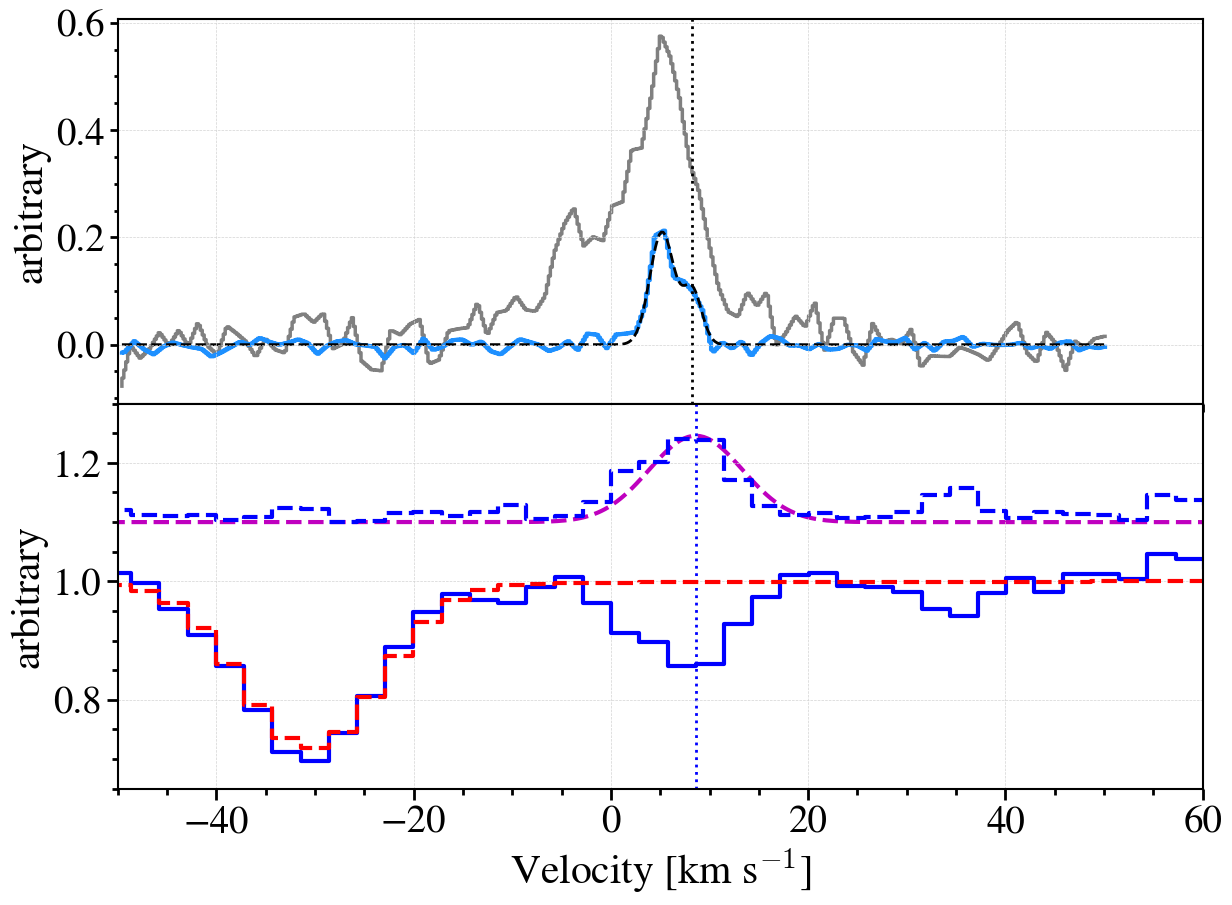

In [ ]:
import matplotlib.gridspec as gridspec
xfactors = {179:0.075, 376: 0.025}


for hi_det_src_id in range(462):
    star_id = ggdf[ggdf.src_id == hi_det_src_id].star_id.values[0]


    if hi_det_src_id not in [376]:
        continue

    # GASKAP source
    gaskap_src = df_det.iloc[hi_det_src_id]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat
    print('src_glon, src_glat: ', src_glon, src_glat)


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    # compute sum of gaussians
    hi_tau_arr = np.zeros_like(vlsr_gaskap)
    for i in range(ncnm):
        hi_tau_arr += gaussian(vlsr_gaskap, hgtcnm[i], cencnm[i], widcnm[i])


    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'

    closest_star_info = galah[galah['sobject_id'] == star_id]

    glon_star = closest_star_info['l'].data[0]
    glat_star = closest_star_info['b'].data[0]
    sep_distance = get_angular_distance(src_glon, src_glat, glon_star, glat_star)


    field_id = closest_star_info['field_id'].data[0]
    path = data_path / 'galah' / f'field_{field_id}'
    make_dir(path)

    sobject_id_str = str(star_id)
    output_star_id_file = path / f'{sobject_id_str}_allstar_fit_spectrum.fits'
    download_galah_data(path, star_id)

    # stellar data: wavelength, flux, model
    tmp_spec_table = Table.read(output_star_id_file)

    wavelength = tmp_spec_table['wave']
    flux = tmp_spec_table['sob']
    flux_mod = tmp_spec_table['smod']

    # for KI
    waverange_idx = np.where((wavelength > 7695.5) & (wavelength < 7704.))[0] # 7720
    ki_wavelength = np.array(wavelength[waverange_idx])
    ki_flux = np.array(flux[waverange_idx])
    ki_flux_mod = np.array(flux_mod[waverange_idx])

    star_glon = closest_star_info['l'].data[0]
    star_glat = closest_star_info['b'].data[0]

    star_rv_comp_1 = closest_star_info['rv_comp_1'].data[0] # km/s
    print('STAR rv_comp_1: ', star_rv_comp_1)

    # Residuels, |model - data|
    res = np.abs(ki_flux_mod - ki_flux)
    max_res_id = np.argmax(res)
    ki_nu_max_res = ki_wavelength[max_res_id]


    # VSLRK of the max KI residual
    ki_ism_vlsr_obs = wavelength_to_vlsrk_with_galah_correction(ki_nu_max_res, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)

    # the width of Ki absorption feature (in Angstrom)
    sigma_k_ism_star_val = closest_star_info['sigma_k_is'].data[0]
    vel_sigma_k_ism_val  = c*sigma_k_ism_star_val / lambda_rest
    vel_fwhm_k_ism_val   = 2 * np.sqrt(2 * np.log(2)) * vel_sigma_k_ism_val
    print('ISM KI widths: ', sigma_k_ism_star_val, vel_sigma_k_ism_val)

    # the Equivalent width of Ki absorption feature (in Angstrom)
    ki_ew_ism_star_val = closest_star_info['ew_k_is'].data[0]

    # the Amplitude of Ki absorption feature (flux vs Angstrom)
    ki_amp = ki_ew_ism_star_val / sigma_k_ism_star_val / np.sqrt(2.*np.pi) # See Sven's email "KI line depth from EW and width"

    # To VLSRK
    ki_xvlsr = wavelength_to_vlsrk_with_galah_correction(ki_wavelength, lambda_rest, star_glon, star_glat, star_rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25)


    ki_ew_ism_star = str(np.round(ki_ew_ism_star_val, 3))
    glon_star = np.round(closest_star_info['l'].data[0], 3)
    glat_star = np.round(closest_star_info['b'].data[0], 3)
    print('glon_star, glat_star', glon_star, glat_star)

    # distance to star
    star_med_dist = closest_star_info['r_med'].data[0] # pc

    # Given values
    # Convert angular separation to radians
    angular_sep_rad = np.radians(sep_distance)

    # Compute linear separation
    linear_sep_pc = med_dist * angular_sep_rad

    min_emt_id = np.argmin(emt_gaskap)
    emt_min_vlsr = vlsr_gaskap[min_emt_id]


    # Plot spectra
    res = np.abs(ki_flux_mod - ki_flux)
    res_std = np.std( np.concatenate((res[:5], res[-5:])) )
    max_res_id = np.argmax(res)
    max_res_val = res[max_res_id]
    xvlsr_max_res = closest_star_info['ki_v_lsr_radio'].data[0] # From Gaussian fit now, before it was ki_xvlsr[max_res_id]

    # distance to star
    star_med_dist = closest_star_info['r_med'].data[0] # pc

    # Convert angular separation to radians
    angular_sep_rad = np.radians(sep_distance)

    # Compute linear separation
    linear_sep_pc = med_dist * angular_sep_rad



    # Open and load the pickle file
    with open(gaskap_src_file, 'rb') as f:  # "rb" mode means read in binary
        gaskap_res_data = pickle.load(f)

    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']
    tau_gaskap = gaskap_res_data['tau']


    min_emt_id = np.argmin(emt_gaskap)
    emt_min_vlsr = vlsr_gaskap[min_emt_id]
    tau_gaskap_max = tau_gaskap[min_emt_id]

    # Star spectra
    xvlsr_max_res = ki_xvlsr[max_res_id]


    min_ki_mod_id = np.argmin(ki_flux_mod)
    ki_xvlsr_min_mod = ki_xvlsr[min_ki_mod_id]



    #######
    # Grid plot
    mpl.rcParams['axes.linewidth'] = 1.5

    fig = plt.figure(figsize=(14,10))
    gs = gridspec.GridSpec(10, 10)
    ax = plt.subplot(gs[0:5, 0:10])
    ax_cdf = plt.subplot(gs[5:, 0:10],sharex=ax)


    xylabel = 30
    xytlabel = 28


    ## ax
    ax.step(vlsr_gaskap, xfactors[hi_det_src_id]*gaskap_em_closest_em_profile, color='gray', ls='-', zorder=-2, lw=2.5, label='HI emission')

    ax.step(vlsr_gaskap, -np.log(emt_gaskap), color='dodgerblue', ls='-', lw=3, zorder=0, label='HI absorption')
    ax.plot(vlsr_gaskap, hi_tau_arr, 'k--', zorder=0, lw=2, label='HI absorption fit') # GASKAP absorption fit

    ax.axvline(x=cencnm[1], color='k', ls=':', zorder=1, lw=2, label='CNM component $V_\mathrm{0,CNM}$')

    ax.set_ylabel('arbitrary', fontsize=xylabel)

    ax.minorticks_on()
    ax.tick_params(axis='x', labelsize=xytlabel, pad=4)
    ax.tick_params(axis='y', labelsize=xytlabel)
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)


    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

    plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_xlim(-50, 80.)
    ax.set_xlim(-0.25, 4.)




    # KI ax
    ki_lines = []
    ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux, 'b-', lw=3, label='KI absorption')
    ki_lines.append(ki_l1)
    ki_l1, = ax_cdf.step(ki_xvlsr, ki_flux_mod, 'r--', lw=3, label='Stellar model')
    ki_lines.append(ki_l1)

    ki_lines2 = []
    ki_l1, = ax_cdf.step(ki_xvlsr, 1.1 + res, 'b--', lw=3, label=r'Residuals ($|$model$-$data$|$)')
    ki_lines2.append(ki_l1)

    gaussian_curve = gaussian(velocity_range, ki_amp, xvlsr_max_res, vel_fwhm_k_ism_val)
    ki_l1, = ax_cdf.plot(velocity_range, 1.1 + gaussian_curve, 'm--', zorder=1, lw=3, label='Gaussian fit')
    ki_lines2.append(ki_l1)

    ki_l1 = ax_cdf.axvline(x=xvlsr_max_res, color='b', ls=':', zorder=1, lw=2, label='$V_\mathrm{0,KI}$')
    ki_lines2.append(ki_l1)



    # xyticks
    ax_cdf.minorticks_on()
    ax_cdf.tick_params(axis='x', labelsize=xytlabel, pad=4)
    ax_cdf.tick_params(axis='y', labelsize=xytlabel)
    ax_cdf.tick_params(which='both', width=2)
    ax_cdf.tick_params(which='major', length=8)
    ax_cdf.tick_params(which='minor', length=4)

    ax_cdf.set_ylim(0.65,1.3)
    ax_cdf.set_xlim(-50, 60.)

    ax_cdf.set_xlabel(r'Velocity [km s$^{-1}$]', fontsize=xylabel)
    ax_cdf.set_ylabel('arbitrary', fontsize=xylabel)

    ax_cdf.tick_params('y', colors='k')
    ax_cdf.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

    # set the spacing between subplots
    plt.subplots_adjust(left=None,
                        bottom=None,
                        right=None,
                        top=None,
                        wspace=0.,
                        hspace=0.
                        )

    plt.show()
    break